In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from collections import defaultdict
from operator import truediv
from tokenize import group
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple
from copy import copy

def lstsq(x, y):
    """
    helper function to do (linear) least squares
    
    x: 1D array of input values
    y: 1D array of output values
    
    Returns
    -------
    
    (a, b)
   
    where a is the slope and b the intercept.
    
    """
    A = np.vstack([x, np.ones(len(x))]).T
    coefs, *rest = np.linalg.lstsq(A, y, rcond=None)
    return coefs

def pred(x, params, power=10):
    """
    
    given x and y arrays, we first fit a line on
    
    (log_10(x), log_10(y)), using `lstsq`
    
    we obtain params = (a, b).
    
    given new values of x, we can predict using:

    (10^b) * x^a        
    """
    a, b = params
    return power**(b) * x**a

def binned_line_fit(X, Y, nbins=5, eps=0.1, return_bins=False):
    """
    function that bins the X values, compute the min Y within each bin
    and treat the center of each bin as input, and the min Y as output,
    then fit a line and return the params of `lstsq`.
    """
    hist, bins = np.histogram(X, range=(X.min(), X.max()+eps), bins=nbins)
    X_bins = np.digitize(X, bins)
    X_new = np.zeros(nbins)
    Y_new = np.zeros(nbins)
    mask = np.ones(len(X_new)).astype(bool)
    assert X_bins.max() == nbins
    for i in range(nbins):
        center = (bins[i] + bins[i+1]) /2
        ymin = Y[X_bins==i+1].min()
        if np.isnan(ymin):
            mask[i] = False
        X_new[i] = center
        Y_new[i] = ymin  
    X_new = X_new[mask]
    Y_new = Y_new[mask]
    params = lstsq(X_new, Y_new)
    if return_bins:
        return params, bins
    else:
        return params

plt.rcParams.update({'font.size': 15})
upstream_colors = {
    "LAION-80M": "blue",
    "LAION-400M": "orange",
    "LAION-2B": "green",
    "CLIP-WIT": "black",
}
upstream_colors2 = {
    "LAION-80M": "orange",
    "LAION-400M": "orange",
    "LAION-2B": "orange",
    "CLIP-WIT": "blue",
}
upstream_dataset_styles = {
    "LAION-80M": "v",
    "LAION-400M": "o",
    "LAION-2B": "s",
    "CLIP-WIT": "*",

}
upstream_order = ["LAION-80M", "LAION-400M", "LAION-2B"]
samples_seen_sizes = {
    "3B": 100,
    "13B": 150,
    "34B": 300,
}
samples_seen_order = ["3B", "13B", "34B"]
arch_order = ["ViT-B/32", "ViT-B/16", "ViT-L/14", "ViT-H/14", "ViT-g/14"]
arch_sizes = {
    "ViT-B/32": 40, 
    "ViT-B/16": 80, 
    "ViT-L/14": 120,
    "ViT-H/14": 160, 
    "ViT-g/14": 200,
}
model_styles = {
    "ViT-B/32": "v", 
    "ViT-B/16": "o", 
    "ViT-L/14": "s",
    "ViT-H/14": "P", 
    "ViT-g/14": "*",

}
upstream_sizes = {
    "LAION-80M": 60,
    "LAION-400M": 100,
    "LAION-2B": 180,
    "CLIP-WIT": 100,
}
target_pretty = {
    "imagenet1k": "ImageNet",
    "mscoco_captions": "MS-COCO",
    "vtab+": "VTAB+",
    "vtab": "VTAB",
    "imagenet_robustness": "ImageNet robustness",
    "flickr30k": "Flickr30K",
}
default_acc_metric = defaultdict(lambda: 'acc1')
default_acc_metric.update({
    'mscoco_captions': 'image_retrieval_recall@5',
    'flickr30k': 'image_retrieval_recall@5',
    'flickr8k': 'image_retrieval_recall@5',
    'voc2007_multilabel': 'mean_average_precision',
})
default_err_metric = defaultdict(lambda: 'err1')
default_err_metric.update({
    'mscoco_captions': 'image_retrieval_1minusrecall@5',
    'flickr30k': 'image_retrieval_1minusrecall@5',
    'flickr8k': 'image_retrieval_1minusrecall@5',
})
metric_pretty = {
    'acc1%': 'Top-1 accuracy %',
    'err1%': 'Error rate %',
    "image_retrieval_recall@5%": 'Image retrieval Recall@5',
    "text_retrieval_recall@5%": 'Text retrieval Recall@5',
    "image_retrieval_1minusrecall@5%": '(100 - Recall@5%)',
    "text_retrieval_1minusrecall@5%": '(100 - Recall@5%)'
}
metric_higher_is_better ={
    "image_retrieval_recall@5%": True,
    "text_retrieval_recall@5%": True,
    "acc1%": True,
    "err1%": False,
}
data_scale = {
    'LAION-80M': 80e6,
    'LAION-400M': 400e6,
    'LAION-2B': 2e9,
    'CLIP-WIT': 400e6,
}
task_metric  = {
    "imagenet": "err1%",
    "image_retrieval": 'image_retrieval_1minusrecall@5%',
    "text_retrieval": 'text_retrieval_1minusrecall@5%',
}

In [2]:
df = pd.read_csv("zeroshot_results.csv")
df['data_scale'] = df.upstream_dataset.apply(lambda d:data_scale[d])
df['image_retrieval_recall@5%'] = df['image_retrieval_recall@5'] * 100.0
df['text_retrieval_recall@5%'] = df['text_retrieval_recall@5'] * 100.0
df['image_retrieval_1minusrecall@5'] = 1 - df['image_retrieval_recall@5']
df['text_retrieval_1minusrecall@5'] =1 - df['image_retrieval_recall@5']
df['image_retrieval_1minusrecall@5%'] = 100*(1 - df['image_retrieval_recall@5'])
df['text_retrieval_1minusrecall@5%'] = 100*(1 - df['image_retrieval_recall@5'])
df['err1'] = df.apply(lambda row: (1-row[default_acc_metric[row.downstream_dataset]]), axis=1)
df['acc1%'] = df['acc1'] * 100.0
df['err1%'] = df['err1'] * 100.0
df['Model'] = df.arch.apply(lambda a:'-'.join(a.split('-')[0:-1]) + '/' + a.split('-')[-1])
df['Dataset'] = df['upstream_dataset']
df['Samples seen'] = df['samples_seen_pretty']
df['Dataset source'] = df.upstream_dataset.apply(lambda u:"CLIP-WIT" if u == "CLIP-WIT" else "LAION")

# Zero-Shot Scaling figures

/home/mehdi/.miniconda3/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/home/mehdi/.miniconda3/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


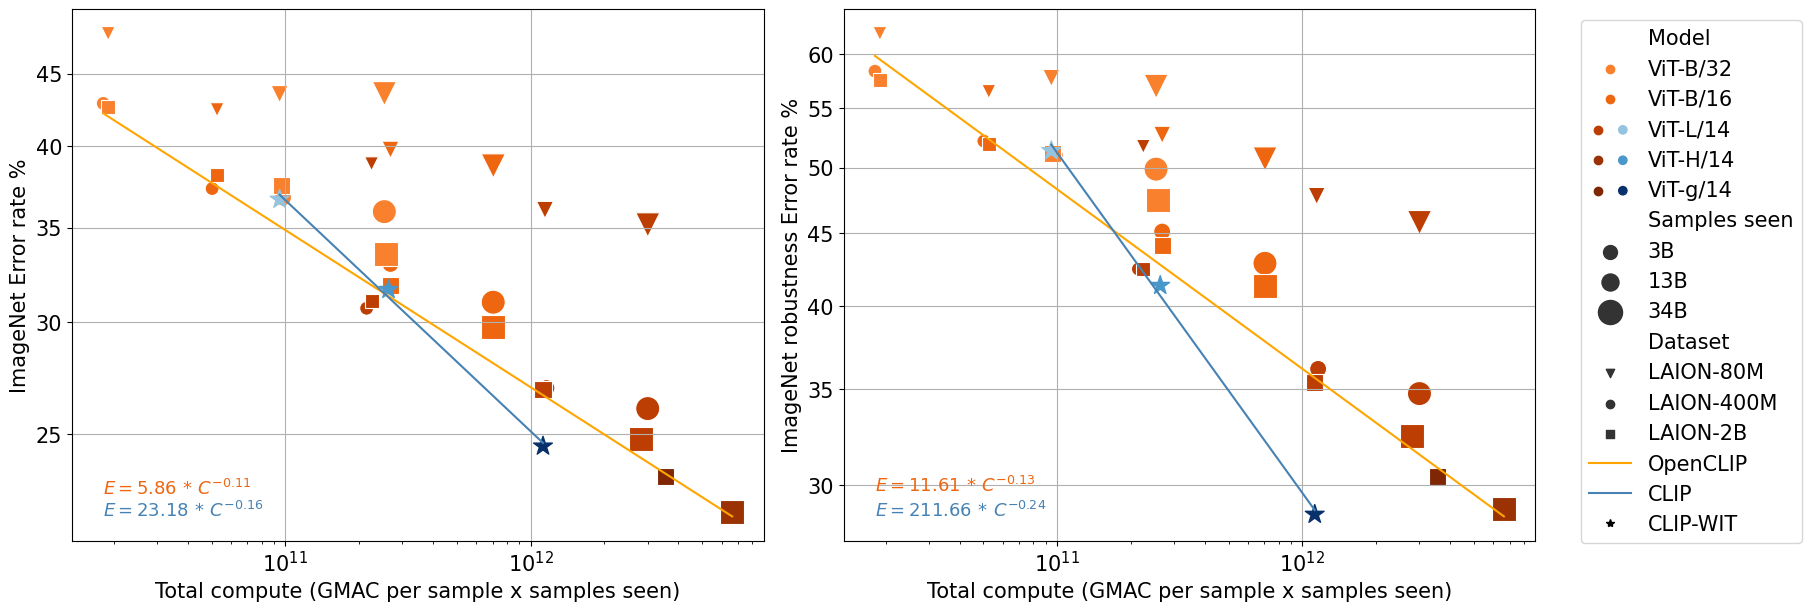

/home/mehdi/.miniconda3/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/home/mehdi/.miniconda3/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


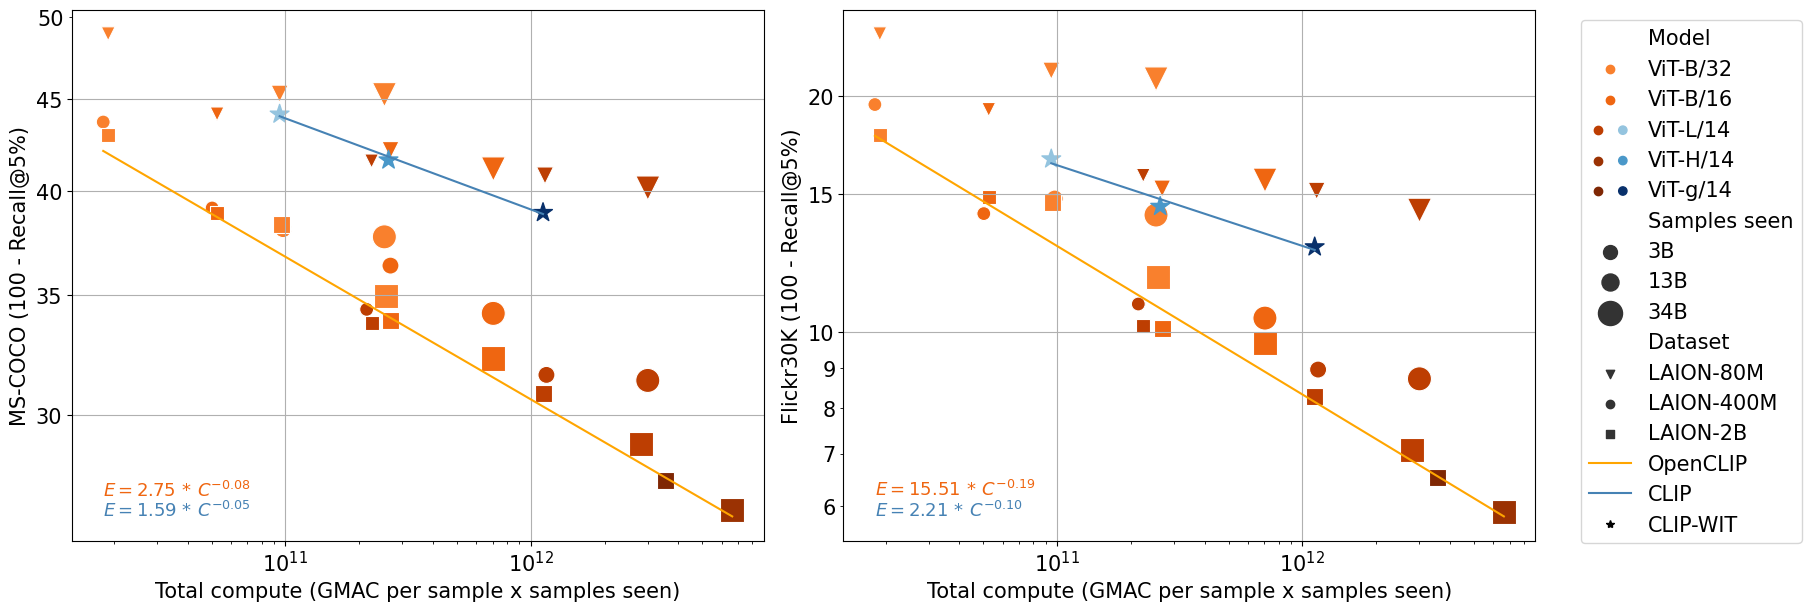

In [3]:
figsize = (18,6)
def get_formula_text(params):
    return f"$E = {10**(params[1]):.2f} \/*\/ C^{{ {params[0]:.2f} }}$"

task_targets = {
    "imagenet": ('imagenet1k', 'imagenet_robustness'),
    "image_retrieval": ('mscoco_captions', 'flickr30k'),
    "text_retrieval": ('mscoco_captions', 'flickr30k'),
}
for task in ("imagenet", "image_retrieval"):
    fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=figsize)
    porange = cm.get_cmap('Oranges', 12)
    new_porange = porange(np.linspace(0.5, 1, len(arch_order) ))#
    names = task_targets[task]
    metric = task_metric[task]
    for ax, tgt in zip(axes, names):
        d = df[df.downstream_dataset==tgt]
        d = d.sort_values(by='gmacs_total')
        d_openclip = d[d.upstream_dataset != "CLIP-WIT"]
        d_openai = d[d.upstream_dataset == "CLIP-WIT"]
        X = np.log10(d_openclip.gmacs_total)
        Y = np.log10(d_openclip.err1)
        line_fit_loglog_openclip = binned_line_fit(X, Y, nbins=5)    
        line_fit_loglog_openai = lstsq(np.log10(d_openai.gmacs_total), np.log10(d_openai.err1))
        d["styles"] = d.upstream_dataset.apply(lambda f:upstream_dataset_styles[f])
        d = d.sort_values(by=["Dataset source", "data_scale"])
        sns.scatterplot(
            data=d_openclip.sort_values(by="data_scale"),
            x='gmacs_total',
            y='err1%',
            hue="Model",
            palette=new_porange,
            hue_order=arch_order,
            size="Samples seen",
            size_order=samples_seen_order,
            sizes=samples_seen_sizes,
            style='Dataset',
            markers=upstream_dataset_styles,
            ax=ax,
            s=120,
        )
        # OpenCLIP line
        x = d_openclip.gmacs_total.values
        y = (100* pred(d_openclip.gmacs_total, line_fit_loglog_openclip)).values
        ax.plot(x, y, color='orange', label='OpenCLIP')#, linestyle='dashed')
        xm = x.min()
        ym = y.min()
        shift = abs(y[-1] - y[-2]) * 0.5
        ax.annotate(get_formula_text(line_fit_loglog_openclip), xy=(xm, ym+shift), rotation=0, fontsize=13, color=new_porange[1])
        # OpenAI line
        x = d_openai.gmacs_total.values
        y = 100*pred(d_openai.gmacs_total, line_fit_loglog_openai).values
        ax.plot(x, y, color='steelblue', ms=10, label="CLIP")
        openai_cols = cm.get_cmap('Blues')
        openai_cols = [openai_cols(0.4), openai_cols(0.6), openai_cols(1.0)]
        ax.scatter(d_openai.gmacs_total.values, d_openai['err1%'].values, marker='*', s=200, c=openai_cols)
        ax.annotate(get_formula_text(line_fit_loglog_openai), xy=(xm, ym),rotation=0, fontsize=13, color='steelblue')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
        ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
        ax.set_xlabel("Total compute (GMAC per sample x samples seen)")
        ax.set_ylabel(f"{target_pretty.get(tgt, tgt)} {metric_pretty[metric]}")
        minv = d_openclip['err1%'].min()
        maxv = d_openclip['err1%'].max()
        unit = 5
        minv = unit * (minv // unit + 1)
        maxv = unit * (maxv // unit + 1)
        ax.grid(True,)
        ax.set_yticks( np.arange(minv, maxv, unit) )
        if ax == axes[1]:
            from matplotlib.lines import Line2D
            ax.legend(bbox_to_anchor=(1.4,1))
            handles, labels = ax.get_legend_handles_labels()
            start = 3
            end = 6
            for i in range(start, end):
                hnew = copy(handles[i])
                hnew.set_facecolors([openai_cols[i-start], "none"])
                hnew.set_edgecolors([openai_cols[i-start], "none"])
                handles[i] = (handles[i], hnew)
            hnew = Line2D([0], [0], marker='*', c='black', linestyle='')
            handles.append(hnew)
            labels.append("CLIP-WIT")
            l = ax.legend(bbox_to_anchor=(1.4,1), labels=labels, handles=handles, handler_map={tuple: HandlerTuple(None)})
        else:
            ax.legend().set_visible(False)
    if task == "imagenet":
        plt.savefig(f"gmacs_vs_perf_imagenet_and_robustness.pdf")
    elif task == "image_retrieval":
        plt.savefig(f"gmacs_vs_perf_image_retrieval.pdf")
    elif task == "text_retrieval":
        plt.savefig(f"gmacs_vs_perf_text_retrieval.pdf")
    plt.show()

# Zero-shot prediction plot

Predictions of imagenet1k performance based on log-log error model:
MAE: 0.8743712188927529


<Figure size 640x480 with 0 Axes>

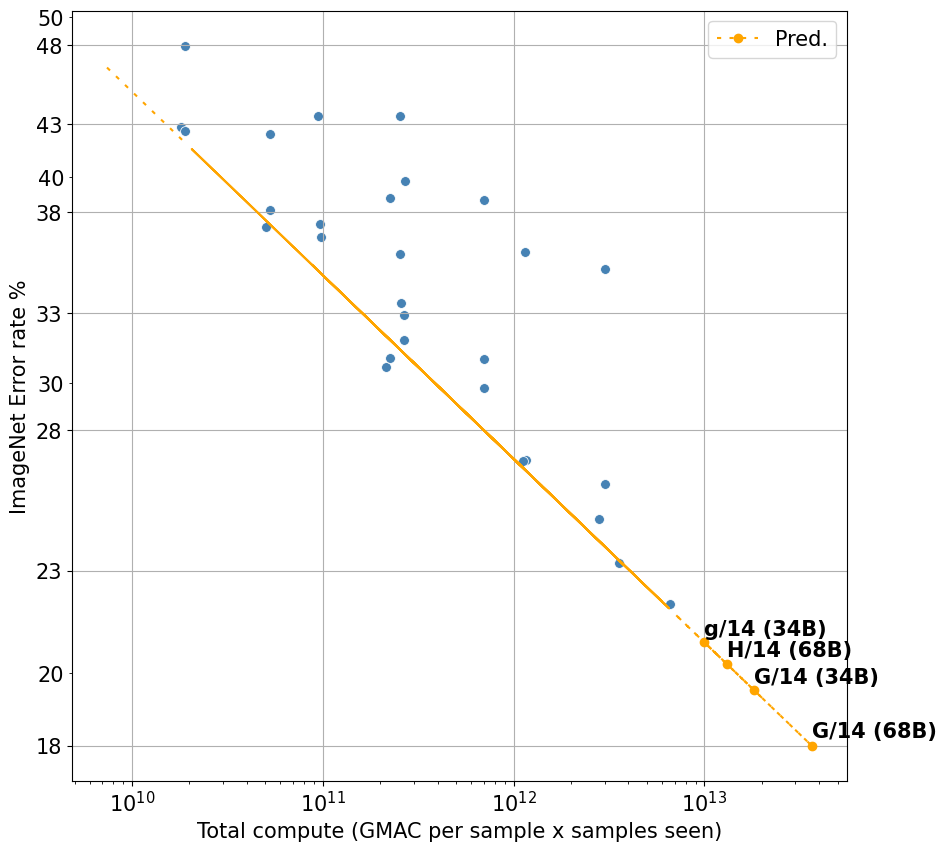

In [4]:
meta = pd.read_csv("arch_info.csv").set_index("model")
_1b = 1e9
_3b = 80000415 * 32
_13b = 407332084 * 32
_34b = 407332084 * 84
_68b = _34b * 2
preds = []
samples_seen = [
    _1b,
    _3b, 
    _13b, 
    _34b, 
    _68b, 
]
samples_seen_names = ["1B", "3B", "13B", "34B", "68B"]
archs = ["ViT-B-32", "ViT-B-16", "ViT-L-14", "ViT-H-14", "ViT-g-14", "ViT-G-14",]
for target in ("imagenet1k",):
    d = df[df.downstream_dataset==target]
    d = d[d.arch.isin(archs)]
    d = d.sort_values(by='gmacs_total')
    d = d[d.upstream_dataset != "CLIP-WIT"]
    X = np.log10(d.gmacs_total)
    Y = np.log10(d["err1"])
    line_fit = binned_line_fit(X, Y, nbins=5)
    fig = plt.figure()
    print(f"Predictions of {target} performance based on log-log error model:")
    rows = []
    for arch in archs:
        for seen in samples_seen:
            gmacs_per_sample = float(meta.loc[arch].gmacs)
            gmacs_total = seen * gmacs_per_sample
            seen_pretty = samples_seen_names[np.abs(np.array(samples_seen) - seen).argmin()]
            actual = d[(d.arch==arch)&(d.samples_seen_pretty==seen_pretty)]["err1"].values
            label = f"{arch.replace('ViT-', '').replace('-','/')} ({seen_pretty})"
            rows.append({
                "gmacs_total": gmacs_total,
                "pred": pred(gmacs_total, line_fit)*100,
                "actual": actual.min()*100 if len(actual) else None,
                "label": label,
            })
    df_pred = pd.DataFrame(rows)
    preds.append(df_pred)
    df_pred['pred_acc%'] = 100 - df_pred['pred']
    df_pred['actual_acc%'] = 100 - df_pred['actual']
    has_gt = ~pd.isna(df_pred.actual)
    mean_absolute_error = (df_pred.pred[has_gt] - df_pred.actual[has_gt]).abs().mean()
    print(f"MAE: {mean_absolute_error}")

    fig, ax = plt.subplots(figsize=(10,10), constrained_layout=False)
    d["styles"] = d.upstream_dataset.apply(lambda f:upstream_dataset_styles[f])
    d = d.sort_values(by=["Dataset source", "data_scale"])
    OUT_LEFT = [
        "B/32 (1B)",
        "B/16 (1B)",
        "L/14 (1B)",
    ]
    OUT_RIGHT = [
        "g/14 (34B)",
        "H/14 (68B)",
        "G/14 (34B)",
        "G/14 (68B)",
    ]
    df_pred_in = df_pred[~df_pred.label.isin(OUT_RIGHT)]
    df_pred_out = df_pred[df_pred.label.isin(OUT_RIGHT)]
    df_pred_out_left = df_pred[df_pred.label.isin(OUT_LEFT)]
    sns.scatterplot(
        data=d.sort_values(by="data_scale"),
        x='gmacs_total',
        y='err1%',
        ax=ax,
        s=50,
        color='steelblue',
    )
    m_right = (df_pred.gmacs_total > d.gmacs_total.max())
    m_left = (df_pred.gmacs_total <= d.gmacs_total.nsmallest(2).iloc[1])
    m = m_left | m_right
    ax.plot(df_pred.gmacs_total[~m], df_pred.pred[~m], color='orange')
    ax.plot(df_pred.gmacs_total[m_right], df_pred.pred[m_right], color='orange', linestyle=(0,  (2,4)))
    ax.plot(df_pred_out.gmacs_total, df_pred_out.pred, color='orange', marker='o',linestyle=(0,  (2,4)), label="Pred.")
    ax.plot(df_pred.gmacs_total[m_left], df_pred.pred[m_left], color='orange', linestyle=(0,  (2,4)))
    for _, row in df_pred_out.iterrows():
        plt.text(row.gmacs_total, row.pred+0.2, row.label, size='medium', color='black', weight='semibold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax.set_xlabel("Total compute (GMAC per sample x samples seen)")
    ax.set_ylabel(f"{target_pretty[target]} {metric_pretty[default_err_metric[target]+'%']}")
    minv = df_pred.pred.min()-0.5
    maxv = df_pred.pred.max()
    unit = 5
    minv = int(unit * (minv // unit + 1))
    maxv = int(unit * (maxv // unit + 1))
    minv = (df_pred.pred.min())
    ax.grid(True,)
    ext = df_pred_out.pred.values.tolist()
    ax.set_yticks( list(np.arange(minv, maxv, unit))  )
    ax.legend().set_visible(True)
    plt.savefig(f"prediction_plot_{target}.pdf")
    plt.show()

In [5]:
df_pred[['label', 'pred_acc%', 'actual_acc%']]

,label,pred_acc%,actual_acc%
0,B/32 (1B),53.394741,NaN
1,B/32 (3B),58.027829,57.358
2,B/32 (13B),64.987286,63.228
3,B/32 (34B),68.555869,66.474
4,B/32 (68B),70.892272,NaN
5,B/16 (1B),58.411032,NaN
6,B/16 (3B),62.545443,62.684
7,B/16 (13B),68.755830,68.134
8,B/16 (34B),71.940313,70.222
9,B/16 (68B),74.025240,NaN


# Scaling curves (interactive)

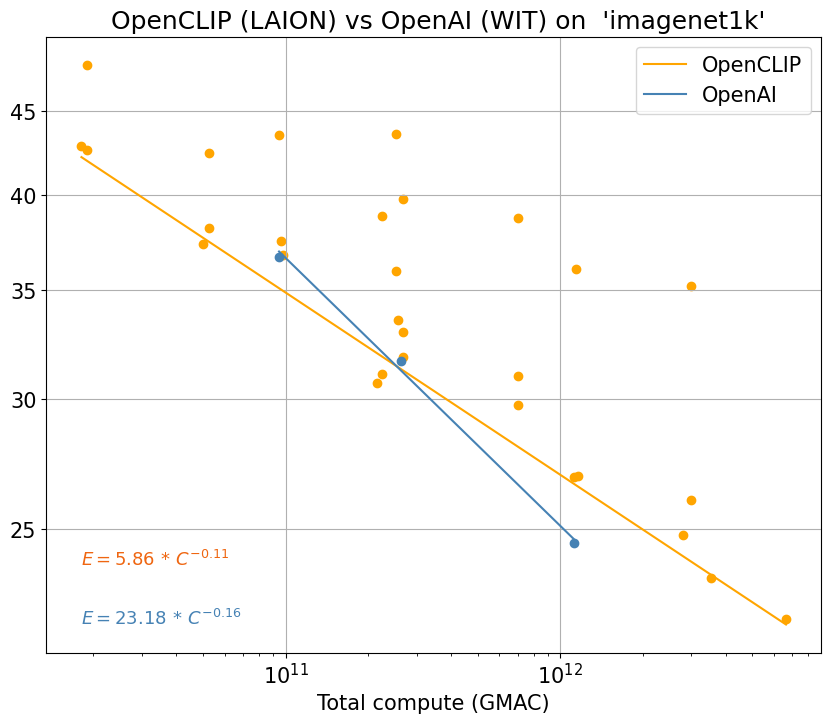

Dropdown(description='Dataset:', index=8, layout=Layout(width='max-content'), options=('cars', 'country211', '…

In [27]:
import ipywidgets as widgets
from IPython.display import clear_output

def update(b):    
    clear_output()
    fig = plt.figure(figsize=(10,8))
    target = dataset_widget.value    
    d = df[df.downstream_dataset==target]
    d = d.sort_values(by='gmacs_total')
    d_openclip = d[d.upstream_dataset != "CLIP-WIT"]
    X = np.log10(d_openclip.gmacs_total)
    Y = np.log10(d_openclip["err1"])
    line_fit_openclip = binned_line_fit(X, Y, nbins=5)
    plt.scatter(d_openclip.gmacs_total, d_openclip['err1%'], c='orange')
    x = d_openclip.gmacs_total.values
    y = 100*pred(d_openclip.gmacs_total, line_fit_openclip).values
    plt.plot(x, y, color='orange', ms=10, label="OpenCLIP")
    
    
    xm = x.min()
    ym = y.min()
    shift = abs(y[-1] - y[-2]) * 1.2
    plt.annotate(get_formula_text(line_fit_openclip), xy=(xm, ym+shift), rotation=0, fontsize=13, color=new_porange[1])


    d_openai = d[d.upstream_dataset == "CLIP-WIT"]
    
    X = np.log10(d_openai.gmacs_total)
    Y = np.log10(d_openai["err1"])
    line_fit_openai = lstsq(X, Y)
    plt.scatter(d_openai.gmacs_total, d_openai['err1%'],  c="steelblue")
    x = d_openai.gmacs_total.values
    y = 100*pred(d_openai.gmacs_total, line_fit_openai).values
    shift = 0
    plt.annotate(get_formula_text(line_fit_openai), xy=(xm, ym), rotation=0, fontsize=13, color='steelblue')
    
    plt.plot(x, y, color='steelblue', ms=10, label="OpenAI")
    plt.title(f" OpenCLIP (LAION) vs OpenAI (WIT) on  '{target}'")
    plt.xlabel("Total compute (GMAC)")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    minv = d_openclip['err1%'].min()
    maxv = d_openclip['err1%'].max()
    unit = 5
    minv = unit * (minv // unit + 1)
    maxv = unit * (maxv // unit + 1)
    plt.grid("True")
    plt.yticks( np.arange(minv, maxv, unit) )
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

    plt.show()
    display(dataset_widget)
    
dataset_widget = widgets.Dropdown(
    options=sorted(list(df.downstream_dataset.unique())),
    value='imagenet1k',
    description='Dataset:',
    disabled=False,
    layout={'width': 'max-content'},
)
dataset_widget.on_trait_change(update, name="value")
update(dataset_widget)

# Zero-shot Imagenet classification learning curves (interactive)

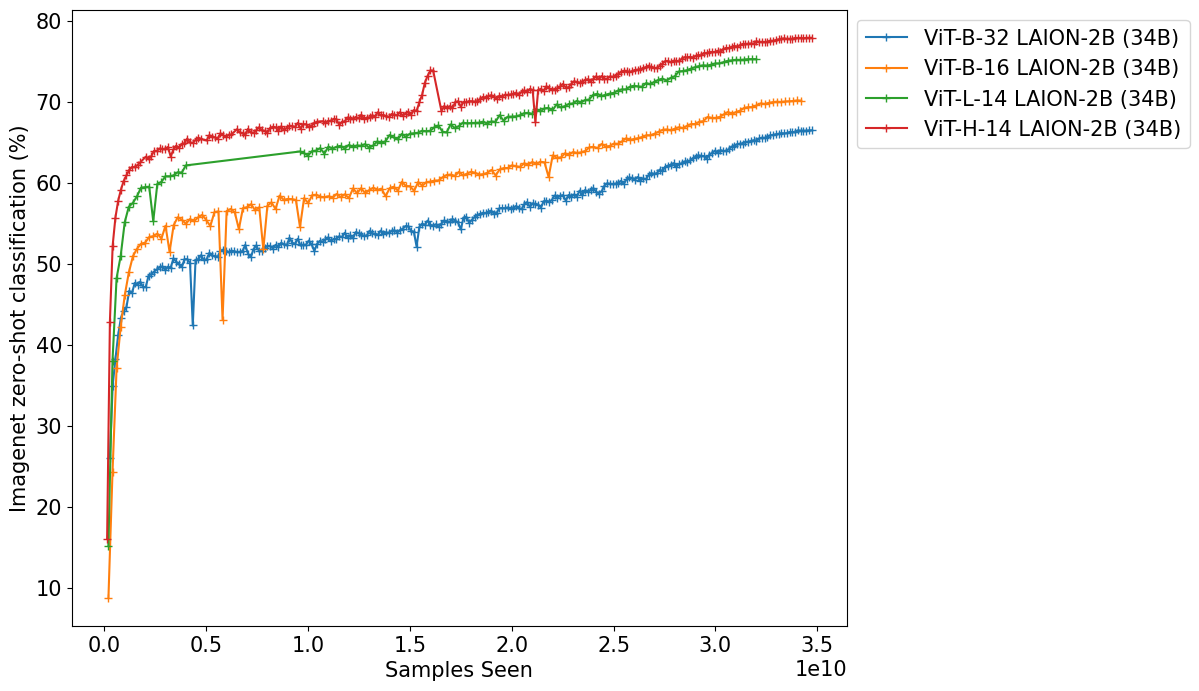

In [25]:
import ipywidgets as widgets
from IPython.display import clear_output

arch_info = pd.read_csv("arch_info.csv").set_index("model")
info = pd.read_csv("trained_models_info.csv")
info = info.set_index("name")
zs_learning_curves = pd.read_csv("imagenet_zeroshot_learning_curves.csv")
zs_learning_curves["samples_seen"] = zs_learning_curves.apply(lambda r:r['epoch'] * info.loc[r['name'], 'samples_per_epoch'], axis=1)
zs_learning_curves["arch"] = zs_learning_curves.apply(lambda r:info.loc[r['name'], 'arch'], axis=1)
zs_learning_curves["gmac_total"] = zs_learning_curves.apply(lambda r:info.loc[r['name'], 'samples_per_epoch'] * info.loc[r['name'], 'epochs'] * arch_info.loc[r['arch'], 'gmacs'] , axis=1)
zs_learning_curves["samples_seen_total"] = zs_learning_curves.apply(lambda r:info.loc[r['name'], 'samples_seen_pretty'], axis=1)
zs_learning_curves["data"] = zs_learning_curves.apply(lambda r:"LAION-"+info.loc[r['name'], 'data'], axis=1)
zs_learning_curves["steps"] = zs_learning_curves.apply(lambda r:r['epoch'] * info.loc[r['name'], 'samples_per_epoch'] / (info.loc[r['name'], 'local_bs']*info.loc[r['name'], 'gpus']), axis=1)
zs_learning_curves['acc1'] = zs_learning_curves['imagenet-zeroshot-val-top1'] * 100
def update(b):
    clear_output()
    fig = plt.figure(figsize=(10,8))
    lcs = zs_learning_curves
    lcs = lcs[lcs.arch.isin(w_arch.value)]
    lcs = lcs[lcs.data.isin(w_data.value)]
    lcs = lcs[lcs.samples_seen_total.isin(w_samples_seen.value)]
    lcs = lcs.sort_values(by="gmac_total")
    for name in lcs.name.unique():
        lc = zs_learning_curves[zs_learning_curves.name==name]
        lc = lc.sort_values(by="epoch")
        name_pretty = info.loc[name, "arch"] + " " + "LAION-"+info.loc[name, "data"]  + " (" + info.loc[name, "samples_seen_pretty"] + ")"
        field = {
            "Epoch": "epoch",
            "Samples Seen": "samples_seen",
            "Step": "steps"
        }[w_xaxis.value]
        plt.plot(lc[field], lc['acc1'], label=name_pretty, marker='+')
        plt.ylabel("Imagenet zero-shot classification (%)")
        plt.xlabel(w_xaxis.value)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    display(box)

w_arch = widgets.SelectMultiple(
    options=['ViT-B-32', 'ViT-B-16', 'ViT-L-14', 'ViT-H-14', 'ViT-g-14'],
    value=['ViT-B-32', 'ViT-B-16', 'ViT-L-14', 'ViT-H-14', 'ViT-g-14'],
)
w_data = widgets.SelectMultiple(
    options=['LAION-80M', 'LAION-400M', 'LAION-2B'],
    value=['LAION-2B'],
)
w_samples_seen = widgets.SelectMultiple(
    options=['3B', '13B', '34B'],
    value=['34B'],
)
w_xaxis = widgets.Select(
    options=['Epoch', 'Samples Seen', 'Step'],
    value='Samples Seen'
)
w_button = widgets.Button(description="Plot")
w_button.on_click(update)
box = widgets.VBox([
    widgets.HBox([w_arch]),
    widgets.HBox([w_data]),
    widgets.HBox([w_samples_seen]),
    widgets.HBox([w_xaxis]),
    widgets.HBox([w_button]),
])
update(w_button)